In [1]:
# 5 КАРМАНОВ

In [2]:
import pandas as pd
import numpy as np
import prophet
from make_series import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import warnings
from statsmodels.tsa.arima.model import ARIMA


warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


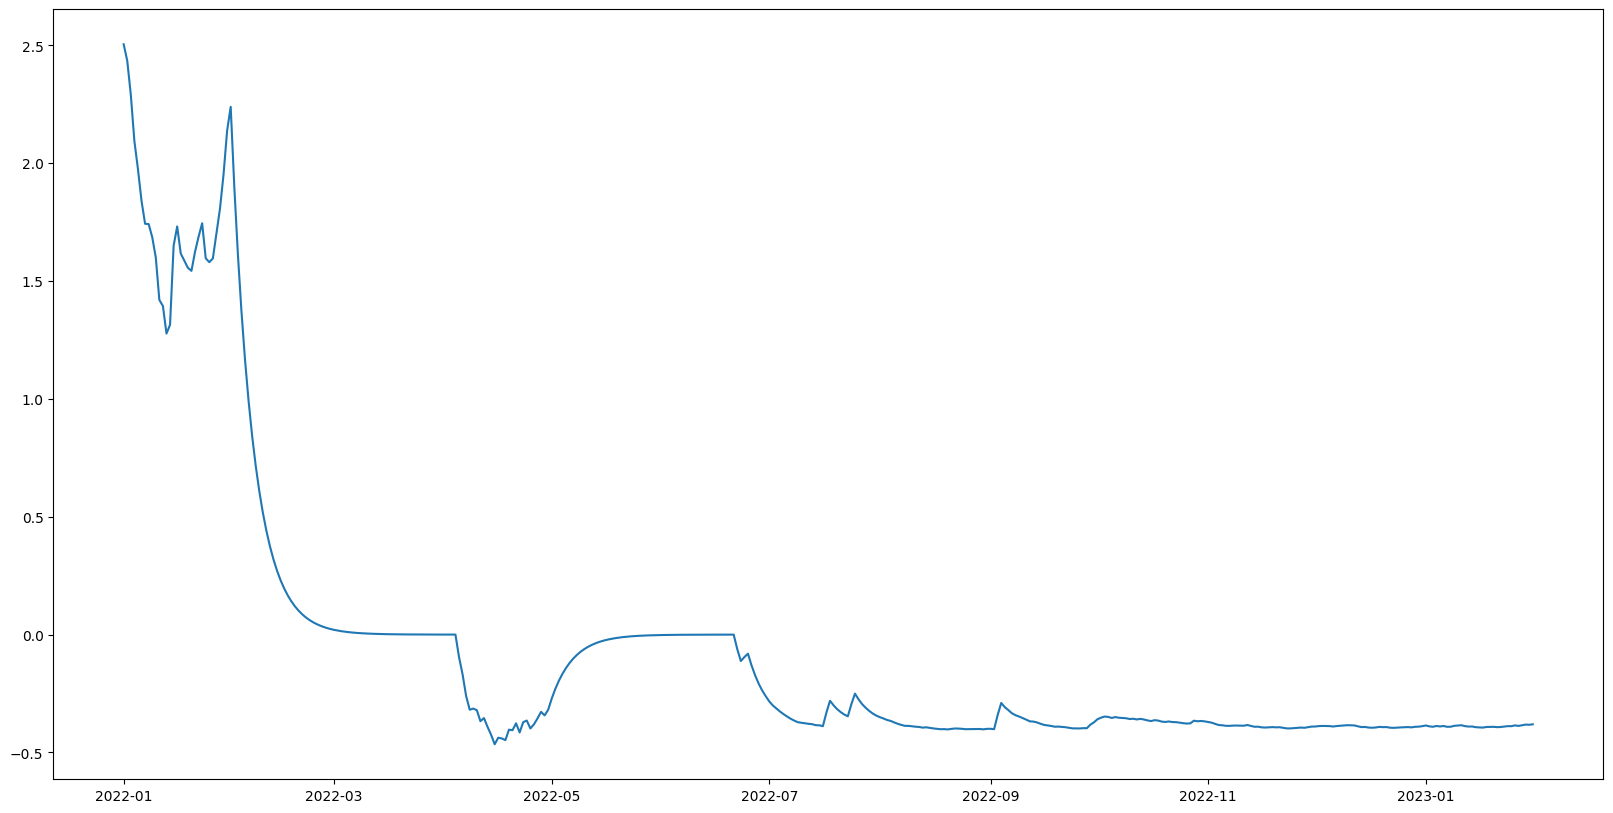

In [3]:
# Соберем нужные данные
df = pd.read_excel('../data/normalized_data.xlsx')
series = make_series(df,'Видеопрокат', is_exponential_smoothing=True)
series_diff = [0.4]
for i in range(1, len(series)):
    series_diff.append(series[i] / series[i-1])

dates = get_all_dates()

# Сделаем из 2 столбцов датафрейм
df = pd.DataFrame({'ds': dates, 'y': series})


df['ds'] = pd.to_datetime(df['ds'])

# Сделаем график series
plt.figure(figsize=(20, 10))
plt.plot(df['ds'], df['y'])
plt.show()

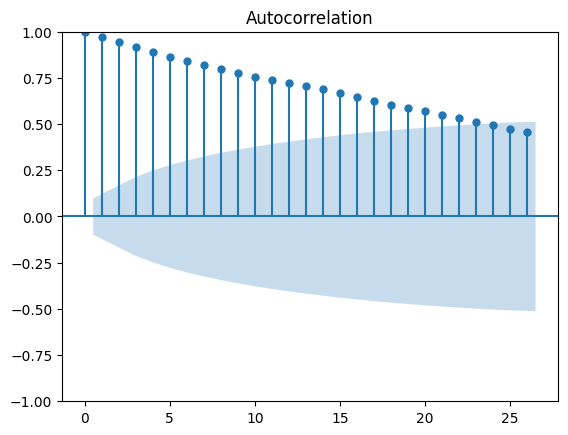

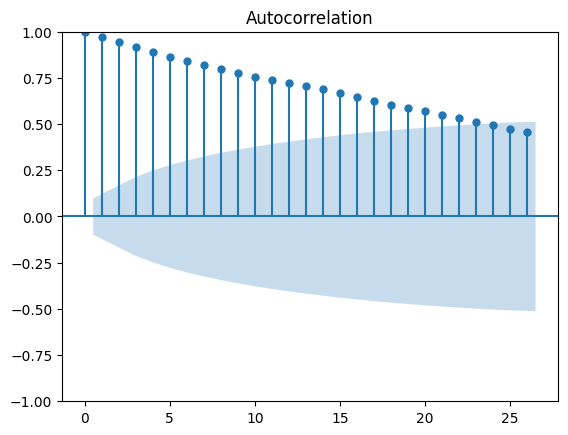

In [4]:
# Построим график автолкорреляции на всех данных
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(np.array(series))


In [5]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                  -4.805290
p-value                          0.000053
#Lags Used                      17.000000
Number of Observations Used    378.000000
Critical Value (1%)             -3.447769
Critical Value (5%)             -2.869217
Critical Value (10%)            -2.570860
dtype: float64


In [6]:
# Создадим модель prophet
model = prophet.Prophet()
# Добавим сезонность
model.add_seasonality(name='monthly', period=300.                        , fourier_order=50)
model.fit(df)



14:42:29 - cmdstanpy - INFO - Chain [1] start processing
14:42:29 - cmdstanpy - INFO - Chain [1] done processing


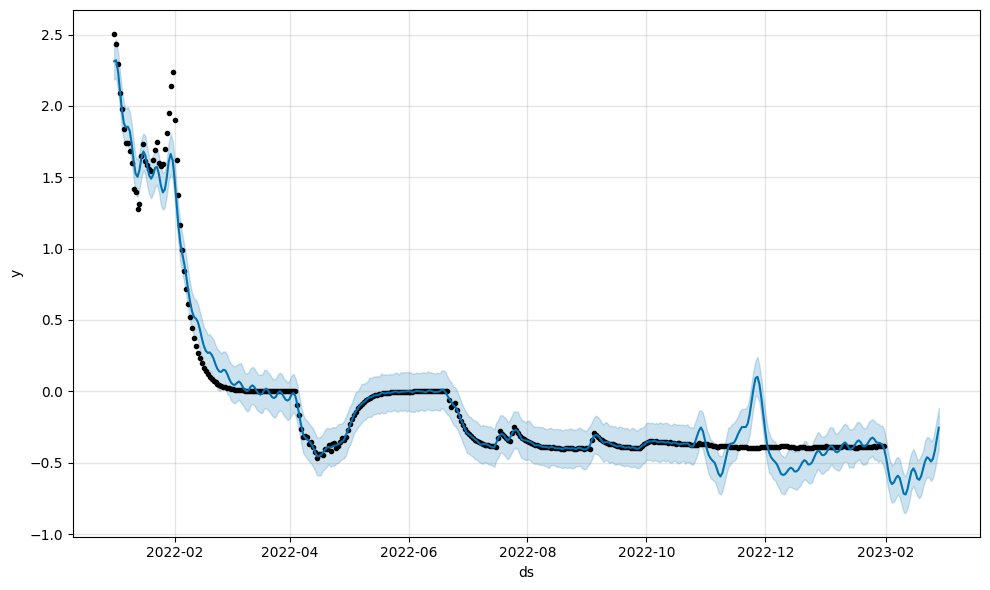

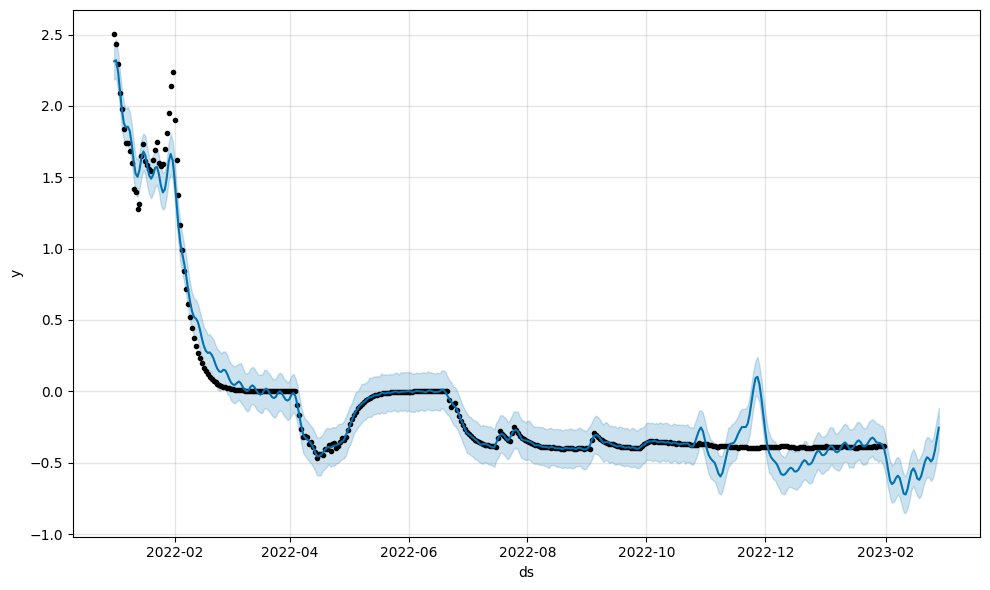

In [7]:
# Построим график реальных значений и предсказанных на тренировочной выборке
future = model.make_future_dataframe(periods=28, freq='D')
forecast = model.predict(future)
model.plot(forecast)


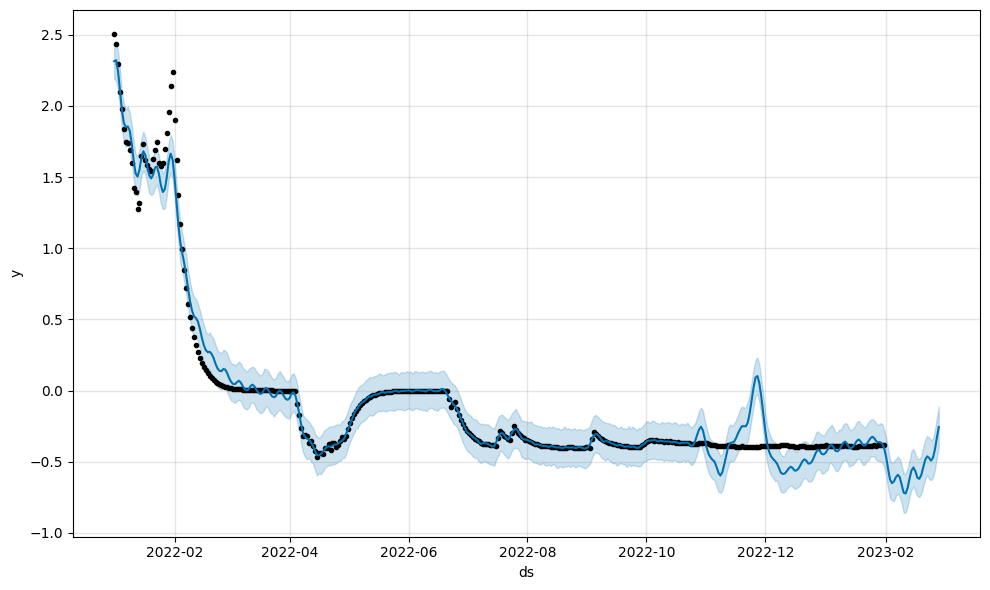

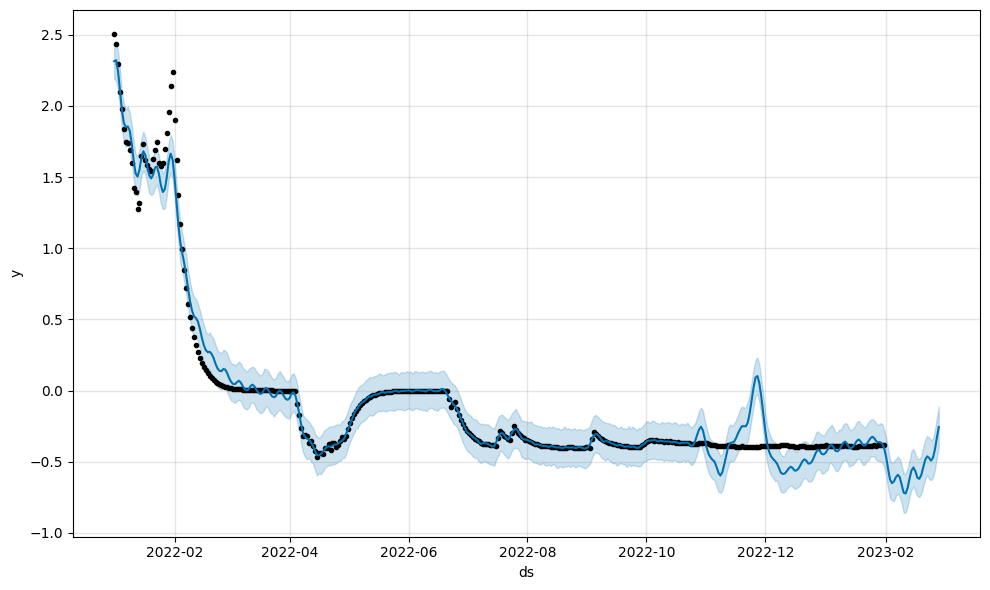

In [8]:
# Предскажем данные еще на месяц
future = model.make_future_dataframe(periods=28, freq='D')
forecast = model.predict(future)
model.plot(forecast)



In [9]:
# Найдем MAE и MAPE
y_true = series
y_pred = forecast['yhat'][:len(series)]
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAE: {mae}')
print(f'MAPE: {mape}')


MAE: 0.05312500436090224
MAPE: 916.0876650023741


In [10]:
# Получим датафрейм из дат и предсказаний
df_forecast = pd.DataFrame({'ds': forecast['ds'], 'y': forecast['yhat']})
df_forecast['ds'] = pd.to_datetime(df_forecast['ds'])

# Вытащим от туда только даты с 2023.02.01 по 2023.02.28
df_forecast = df_forecast[df_forecast['ds'] >= '2023-02-08']
df_forecast

,ds,y
403,2023-02-08,-0.608608
404,2023-02-09,-0.661734
405,2023-02-10,-0.717131
406,2023-02-11,-0.722953
407,2023-02-12,-0.684457
408,2023-02-13,-0.618775
409,2023-02-14,-0.560658
410,2023-02-15,-0.540032
411,2023-02-16,-0.566470
412,2023-02-17,-0.610827


In [11]:
# Найдем среднее и стандартное отклонение кешбека для Bonafide из ../tasks/merch_cb_hack_8_9.csv
df_cb = pd.read_csv('../tasks/merch_cb_hack_8_9.csv')
df_cb = df_cb[df_cb['merchant_name'] == 'Bonafide']
df_cb


,merchant_name,day,month,cashback
7,Bonafide,2023-02-02 00:00:00,2023-02-01 00:00:00,311.03
8,Bonafide,2023-02-03 00:00:00,2023-02-01 00:00:00,396.00
9,Bonafide,2023-02-04 00:00:00,2023-02-01 00:00:00,205.73
10,Bonafide,2023-02-05 00:00:00,2023-02-01 00:00:00,186.14
11,Bonafide,2023-02-06 00:00:00,2023-02-01 00:00:00,764.20


In [12]:
# Найдем среднее и стандартное отклонение кешбека для df_cb
mean_cb = df_cb['cashback'].mean()
std_cb = df_cb['cashback'].std()

def denormalize_value(value, mean, std):
    return value * std + mean

# Создадим столбец с кешбеком
df_forecast['cashback'] = df_forecast['y'].apply(lambda x: denormalize_value(x, mean_cb, std_cb))
df_forecast

,ds,y,cashback
403,2023-02-08,-0.608608,229.790891
404,2023-02-09,-0.661734,217.323162
405,2023-02-10,-0.717131,204.322603
406,2023-02-11,-0.722953,202.956272
407,2023-02-12,-0.684457,211.990530
408,2023-02-13,-0.618775,227.404940
409,2023-02-14,-0.560658,241.043784
410,2023-02-15,-0.540032,245.884443
411,2023-02-16,-0.566470,239.679974
412,2023-02-17,-0.610827,229.270038
